EDA

EDA (Exploratory Data Analysis, разведочный анализ данных) - анализ основных свойств данных, нахождение в них общих закономерностей, распределений и аномалий, построение начальных моделей, зачастую с использованием инструментов визуализации.

## Место EDA в Data Science проекте
EDA выполняется после этапа сбора данных (Data Collection). Результат этапа сбора данных в общем случае не предполагает наличие готового к анализу датасета, поэтому непосредственно перед анализом могут потребоваться дополнительные преобразования данных.

После EDA, как правило, выполняется подготовка данных для моделирования (Data Preparation).

В силу итеративности жизненного цикла задач Data Science возврат к EDA может быть из любого этапа.

## Для чего нужен EDA?
1. Обозначить проблемы, обнаруженные в данных, и по возможности внести исправления как в данные так и в их источники.
2. На основе собранных данных принять корректное решение о возможности продолжения проекта.
3. Найти полезные для бизнеса инсайты без непосредственного моделирования.
4. Подготовиться к следующим этапам жизненного цикла задач Data Science.

## План проведения EDA
EDA может различаться от задачи к задаче, тем не менее можно выделить основные моменты:
1. Получить верхнеуровневое понимание данных:
    - объём данных;
    - за какой период взяты данные;
    - какие группы атрибутов содержатся: социо-демографические, транзакционные, коммуникации с клиентом и т.д;
    - сколько различных типов атрибутов: номинальные, ординальные, числовые, текстовые и т.д.;
    - какие пропорции классов в таргете (для классификации), распределение таргета (для регрессии);
    - если есть интересные для бизнеса группы наблюдений;
2. Проверить качество данных:
    - % пропущенных значений в атрибутах и таргете;
    - наличие выбросов;
    - наличие дубликатов записей;
    - наличие ошибок в данных;
3. Провести одномерный анализ:
    - построить гистограммы распределений (для числовых) или столбчатые диаграммы (для категориальных);
4. Провести корреляционный анализ:
    - построить матрицу корреляции между атрибутами;

Таким образом, этапы EDA могут выглядеть следующим образом:  
1. Получить верхнеуровневое понимание данных.  
2. Проверить качество данных.  
3. Сделать промежуточные выводы о возможности продолжения проекта.    
4. Разработать план по тестированию модели.  
5. Выделить и исключить из датасета тестовую выборку.  
6. Провести одномерный анализ.  
7. Провести корреляционный анализ.   
8. Сделать основные выводы, включая вывод о возможности продолжения проекта.  

In [52]:
# Import dependencies
import logging
import warnings
import numpy as np
import pandas as pd
from scipy import stats


from tools_viz import (
        display_df,
        set_display,
        set_seed,
        show_hist_cat,
        show_histograms,
        show_corr_matrix,
        rank_features
)

from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


# Set initial value for reproducibility results and visualization
seed = 1234
set_seed(seed)
set_display()

THR_PCT_MISS = 30  # % пропущенных значений, выше которого атрибут удаляется

# 0. Загрузка данных
Ниже в качестве примера будет рассматриваться задача анализа оттока клиентов.  
В каждой строке есть таргет (Exited), который показывает статус клиента Active(1) или Lost(0).

In [21]:
# Загрузка данных
data = pd.read_csv('../train.csv')
data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.0,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.0,2,1.0,0.0,184866.69,0


In [22]:
# Приведем названия столбцов к нижнему регистру для удобства
# Добавим уникальный номер состоящий из id и CustomerId
# также удалим стоблец id и CustomerId в этой задаче они не несут нужной информации
# также переимеименум столбец Exited в target, так более понятно

data.columns = data.columns.str.lower()

# data['ids'] = data['id'].astype(str) + '-' + data['customerid'].astype(str) 
data = data.assign(ids=lambda x: x['id'].astype(str) + '-' + x['customerid'].astype(str))
ids='ids'

data = data.drop(columns={'id','customerid'})
data = data.rename(columns = {'exited':'target'})
data.head()

,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,target,ids
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0-15674932
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1-15749177
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,2-15694510
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,3-15741417
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,4-15766172


In [23]:
# Назначим aliasis для некоторыз атрибутов для удобства
SUR = 'surname'
TARGET = 'target'

## Чек-лист для пункта Загрузка данных
- [x] Данные загружены в DataFrame.  

# 1. Верхнеуровневый обзор данных

In [24]:
# Кол-во уникальных клиентов?
print(f"Кол-во уникальных клиентов: "
      f"{data[ids].nunique()}")

# Кол-во категориальных атрибутов?
cat_elim = [SUR, TARGET, ids]
cat_fts = [ft for ft in data.select_dtypes(include='object').columns \
           if ft not in cat_elim]
print(f"Кол-во категориальных атрибутов: {len(cat_fts)}")

# Кол-во числовых атрибутов?
num_elim = [TARGET]
num_fts = [ft for ft in data.select_dtypes(include=('int', 'float')).columns \
           if ft not in num_elim]
print(f"Кол-во числовых атрибутов: {len(num_fts)}")

Кол-во уникальных клиентов: 165034
Кол-во категориальных атрибутов: 2
Кол-во числовых атрибутов: 8


В датасете рассматриваются 2 группы атрибутов:
1. Атрибуты, связанные с онбоардингом клиентов (канал привлечения, дата онбоардинга, тип коробки и т.д.).
2. Атрибуты, связанные с транзакционной активностью на РС.

In [25]:
# Посмотрим на статистику по атрибутам,
# чтобы увидеть возможные некорректные значения
data.describe().T

,count,mean,std,min,25%,50%,75%,max
creditscore,165034.0,656.45437304,80.10334049,350.00,597.00,659.0,710.0000,850.00
age,165034.0,38.12588788,8.86720459,18.00,32.00,37.0,42.0000,92.00
tenure,165034.0,5.02035338,2.80615857,0.00,3.00,5.0,7.0000,10.00
balance,165034.0,55478.08668935,62817.66327784,0.00,0.00,0.0,119939.5175,250898.09
numofproducts,165034.0,1.55445545,0.54715368,1.00,1.00,2.0,2.0000,4.00
hascrcard,165034.0,0.75395373,0.43070712,0.00,1.00,1.0,1.0000,1.00
isactivemember,165034.0,0.49777016,0.49999654,0.00,0.00,0.0,1.0000,1.00
estimatedsalary,165034.0,112574.82273434,50292.86558490,11.58,74637.57,117948.0,155152.4675,199992.48
target,165034.0,0.21159882,0.40844311,0.00,0.00,0.0,0.0000,1.00


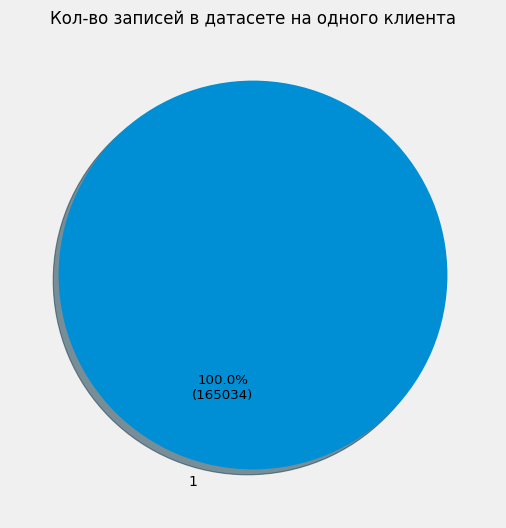

In [26]:
# Так как на один субъект может приходится несколько записей в датасете,
# то целесообразно построить распределение кол-ва записей на одного клиента.
# То есть сколько клиентов с одной записью, сколько с двумя и т.д.
fig, ax = plt.subplots(figsize=(6, 6))
proportion = data.groupby(ids)[ids].count().value_counts(dropna=False).to_dict()
ax.pie(
    x=list(proportion.values()),
    explode=np.linspace(0, 0.5, num=len(proportion)),
    labels=list(proportion.keys()),
    shadow=True,
    autopct=lambda p: f"{p:.1f}%\n({p * sum(proportion.values()) / 100:.0f})",
    startangle=75
)
ax.set(title='Кол-во записей в датасете на одного клиента')

plt.show()

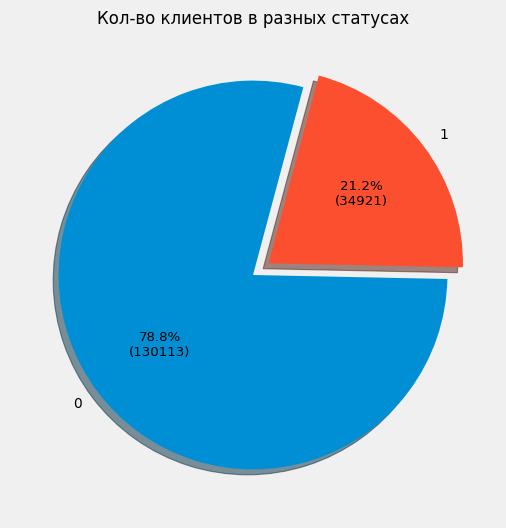

In [27]:
# Посмотрим на распределение клиентов в заивимости от их статуса
fig, ax = plt.subplots(figsize=(6, 6))
proportion = data.groupby(ids)[TARGET].last() \
                 .value_counts(dropna=False).to_dict()
ax.pie(
    x=list(proportion.values()),
    explode=np.linspace(0, 0.1, num=len(proportion)),
    labels=list(proportion.keys()),
    shadow=True,
    autopct=lambda p: f"{p:.1f}%\n({p * sum(proportion.values()) / 100:.0f})",
    startangle=75
)
ax.set(title='Кол-во клиентов в разных статусах')

plt.show()

## Чек-лист для пункта Верхнеуровневый обзор данных
- [x] Указаны группы атрибутов.
- [x] Указаны типы атрибутов.
- [x] Приведены пропорции классов в таргете.

# 2. Проверка качества данных

## 2.2. Проверка дубликатов

In [28]:
# Проверим что у нас нет дубликатов строк
# с одинаковыми 'ids', TARGET
subset = [ids, TARGET]
rec_dupl = data[data.duplicated(subset=subset, keep=False)] \
                .sort_values(by=[ids])
print(f"Кол-во дублей: {len(rec_dupl)}")

Кол-во дублей: 0


## 2.3. Проверка пропущенных значений

In [29]:
# Категориальные атрибуты
cat_missing = data[cat_fts].isnull().sum() / data[cat_fts].index.size * 100
cat_missing = cat_missing[cat_missing > THR_PCT_MISS].sort_values(ascending=False)
print(f"Кол-во категориальных атрибутов с %-ом пропусков > {THR_PCT_MISS}%: "
      f"{len(cat_missing)}")
print(f"Примеры категориальных атрибутов с %-ом пропусков > {THR_PCT_MISS}%:\n"
      f"{cat_missing[:10]}")

# Числовые атрибуты
num_missing = data[num_fts].isnull().sum() / data[num_fts].index.size * 100
num_missing = num_missing[num_missing > THR_PCT_MISS].sort_values(ascending=False)
print(f"Кол-во числовых атрибутов с %-ом пропусков > {THR_PCT_MISS}%: "
      f"{len(num_missing)}")
print(f"Примеры числовых атрибутов с %-ом пропусков > {THR_PCT_MISS}%:\n"
      f"{num_missing[:10]}")

Кол-во категориальных атрибутов с %-ом пропусков > 30%: 0
Примеры категориальных атрибутов с %-ом пропусков > 30%:
Series([], dtype: float64)
Кол-во числовых атрибутов с %-ом пропусков > 30%: 0
Примеры числовых атрибутов с %-ом пропусков > 30%:
Series([], dtype: float64)


In [30]:
# Пропуски больше 30% отсутствуют 
num_fts = [ft for ft in num_fts if ft not in num_missing]
print(f"Кол-во числовых атрибутов: {len(num_fts)}")
print(f"Примеры числовых атрибутов:\n{num_fts[:]}")

Кол-во числовых атрибутов: 8
Примеры числовых атрибутов:
['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']


## 2.4. Проверка выбросов и ошибок

In [31]:
# Снова посмотрим на статистику по атрибутам,
# чтобы увидеть возможные некорректные значения
data[num_fts].describe().T

,count,mean,std,min,25%,50%,75%,max
creditscore,165034.0,656.45437304,80.10334049,350.00,597.00,659.0,710.0000,850.00
age,165034.0,38.12588788,8.86720459,18.00,32.00,37.0,42.0000,92.00
tenure,165034.0,5.02035338,2.80615857,0.00,3.00,5.0,7.0000,10.00
balance,165034.0,55478.08668935,62817.66327784,0.00,0.00,0.0,119939.5175,250898.09
numofproducts,165034.0,1.55445545,0.54715368,1.00,1.00,2.0,2.0000,4.00
hascrcard,165034.0,0.75395373,0.43070712,0.00,1.00,1.0,1.0000,1.00
isactivemember,165034.0,0.49777016,0.49999654,0.00,0.00,0.0,1.0000,1.00
estimatedsalary,165034.0,112574.82273434,50292.86558490,11.58,74637.57,117948.0,155152.4675,199992.48


Из таблицы видно что все значения в пределах нормы, 
только есть максимальное значение по возрасту выделяется, 
предположим что у нас есть такие клиенты и эти данные валидные. Посмотрим на уникальные значения по возрасту.

In [32]:
# здесь мы видим что у нас в возрасте данные сохранены в виде float и есть выбросы, 
# просто приведем значение в столбце возраст к int.

data['age'].unique()

array([33.  , 40.  , 34.  , 36.  , 30.  , 37.  , 43.  , 27.  , 71.  ,
       47.  , 25.  , 55.  , 61.  , 35.  , 41.  , 44.  , 26.  , 39.  ,
       31.  , 58.  , 49.  , 32.  , 50.  , 28.  , 45.  , 52.  , 29.  ,
       38.  , 54.  , 56.  , 46.  , 42.  , 64.  , 20.  , 21.  , 23.  ,
       48.  , 59.  , 51.  , 24.  , 53.  , 62.  , 57.  , 22.  , 66.  ,
       67.  , 19.  , 73.  , 60.  , 63.  , 65.  , 75.  , 68.  , 69.  ,
       76.  , 18.  , 70.  , 81.  , 74.  , 72.  , 77.  , 82.  , 79.  ,
       92.  , 80.  , 78.  , 83.  , 36.44, 85.  , 32.34, 84.  ])

In [33]:
data['age'] = data['age'].astype(int)

## Чек-лист для пункта Проверка качества данных
- [x] Проверено выполнение бизнес-правил.
- [x] Проверено наличие дубликатов.
- [x] Проверено наличие пропущенных значений.
- [x] Проверено наличие выбросов и ошибок.

# 3. Выводы по результатам пп. 1 и 2
1. Для моделирования оттока клиентов собрана информация по 165034 субъектам по следующим атрибутам: 
    - атрибуты, связанные с онбоардингом клиентов; 
    - атрибуты, связанные с транзакционной активностью на РС.  
2. Среди числовых атрибутов нет данных с большим количеством пропусков.
3. В перечне атрибутов отсутствуют такие важные группы как:  
    - атрибуты, описывающие коммуникации с клиентами;
    - атрибуты, описывающие поведение клиентов с ДБО.  

Пп. 3 с высокой вероятностью влияют на качество результата, но не являются стоп-фаторами для адльнейшего анализа.

# 4. Разработка плана по тестированию модели

Для проведения нижеследующих частей EDA целесообразно разделить датасет на train и test, поскольку дальнейшие этапы направлены на изучение связи между атрибутами и атрибутов с таргетом. Основная цель моделирования - получение модели с хорошей обобщающей способностью. Уровень обобщающей способности может быть протестирован на данных, которые модель ранее никогда не видела. Это в том числе означает, что мы не пытаемся извлечь информацию о взаимосвязи атрибутов и таргета из тестовой выборки.  

Разные источники по-разному подходят к этому вопросу, но моя основная рекомендация при возможности выполнять оставшуюся часть EDA только на обучающей выборке, чтобы избежать оптимистичных результатов тестирования модели.

## Чек-лист для пункта Разработка плана по тестированию модели
- [x] Определена методика тестирования модели.

# 5. Разделение датасета на train и test

In [34]:
# ----------- Деление данных на train и test -----------------
# Обозначим типы атрибутов: категориальные, числовые 
cat_elim = [SUR, ids]
cat_fts_global = [ft for ft in data.select_dtypes(include=['bool', 'category', 'object']).columns \
                   if ft not in cat_elim]
print(f"Кол-во категориальных атрибутов: {len(cat_fts_global)}")

num_elim = [ids, TARGET]
num_fts_global = [ft for ft in data.select_dtypes(include=['int', 'float']).columns \
                   if ft not in num_elim]
print(f"Кол-во числовых атрибутов: {len(num_fts_global)}")

features = [*cat_fts_global, *num_fts_global]

print("Деление данных на train и test...")

X = data[features].copy()
y = data[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    shuffle=True,
    stratify=y,
    random_state=seed
)

print("Деление данных на train и test завершено.")

# После разделения на train и test
# посмотрим на распределение классов
print(f"Кол-во наблюдений в X_train (обучающая выборка): {len(X_train)}")
for key, val in dict(Counter(y_train.ravel())).items():
    print(f"Класс {key}: {val} ({val / len(y_train.ravel()) * 100:.2f}%)")
    
print(f"\nКол-во наблюдений в X_test (тестовая выборка): {len(X_test)}")
for key, val in dict(Counter(y_test.ravel())).items():
    print(f"Класс {key}: {val} ({val / len(y_test.ravel()) * 100:.2f}%)")

Кол-во категориальных атрибутов: 2
Кол-во числовых атрибутов: 8
Деление данных на train и test...
Деление данных на train и test завершено.
Кол-во наблюдений в X_train (обучающая выборка): 132027
Класс 0: 104090 (78.84%)
Класс 1: 27937 (21.16%)

Кол-во наблюдений в X_test (тестовая выборка): 33007
Класс 0: 26023 (78.84%)
Класс 1: 6984 (21.16%)


/var/folders/tz/lgvz692s3s715tvxq721j61m0000gn/T/ipykernel_7095/874170374.py:33: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for key, val in dict(Counter(y_train.ravel())).items():
/var/folders/tz/lgvz692s3s715tvxq721j61m0000gn/T/ipykernel_7095/874170374.py:34: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  print(f"Класс {key}: {val} ({val / len(y_train.ravel()) * 100:.2f}%)")
/var/folders/tz/lgvz692s3s715tvxq721j61m0000gn/T/ipykernel_7095/874170374.py:37: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for key, val in dict(Counter(y_test.ravel())).items():
/var/folders/tz/lgvz692s3s715tvxq721j61m0000gn/T/ipykernel_7095/874170374.

## Чек-лист для пункта Разделение датасета на train и test
- [x] Test по своей репрезентативности, сбалансированности и прочим характеристикам максимально похож на реальные данные, которые потом будет получать на вход обученная модель.
- [x] Если в датасете присутствует один и тот же субъект в нескольких экземплярах, например, для Клиента 1 есть 2 записи: старая и новая, то при тестировании или кросс-валидации более новая запись находится в тестовом подмножестве.

# 6. Одномерный анализ

## 6.1. Категориальные признаки

In [35]:
X_train

,geography,gender,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
71021,Germany,Male,560,24,6,149382.82,2,1.0,1.0,179171.48
30024,France,Male,584,32,6,123049.21,1,1.0,1.0,65801.44
108613,Spain,Male,744,39,4,95161.75,1,1.0,1.0,19409.77
146238,Spain,Female,710,67,6,0.00,2,1.0,1.0,84420.67
117342,Germany,Male,705,55,2,131365.37,1,1.0,0.0,64771.61
...,...,...,...,...,...,...,...,...,...,...
109215,France,Male,490,29,4,0.00,2,1.0,1.0,32089.57
3301,France,Male,757,37,4,0.00,2,0.0,0.0,86073.33
86621,France,Female,597,35,2,0.00,1,1.0,0.0,132436.97
48920,France,Male,744,41,5,106260.67,1,1.0,1.0,2578.43


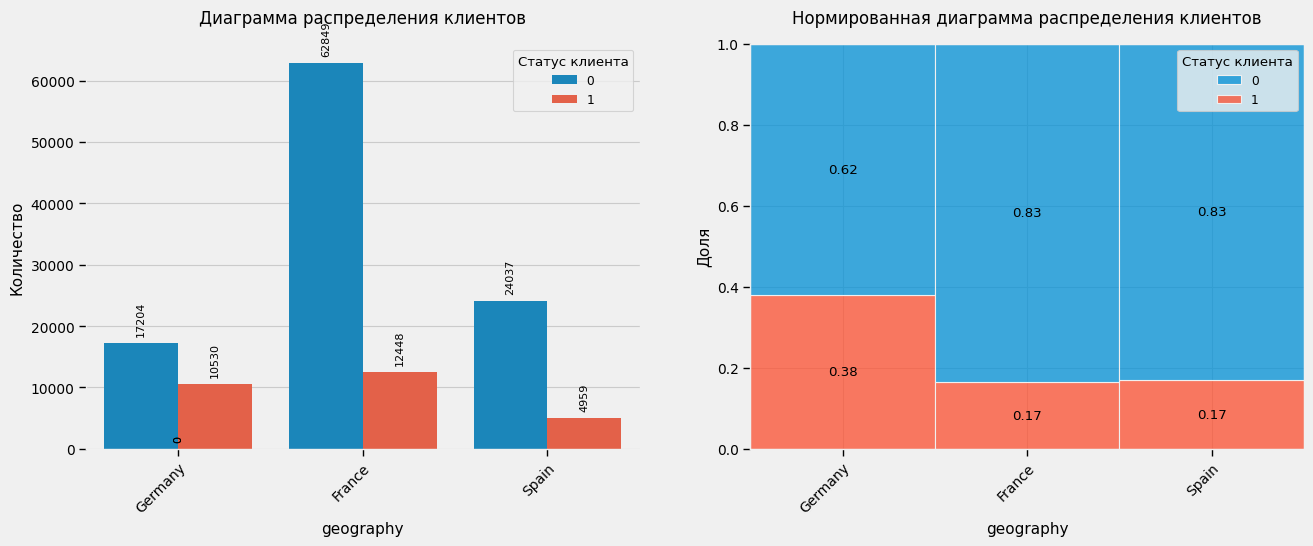

In [36]:
X_train[TARGET] = y_train
target_order = [0, 1]
item = 'geography'
show_hist_cat(X_train, item, TARGET, hue_order=target_order, xlabel=f"{item}")

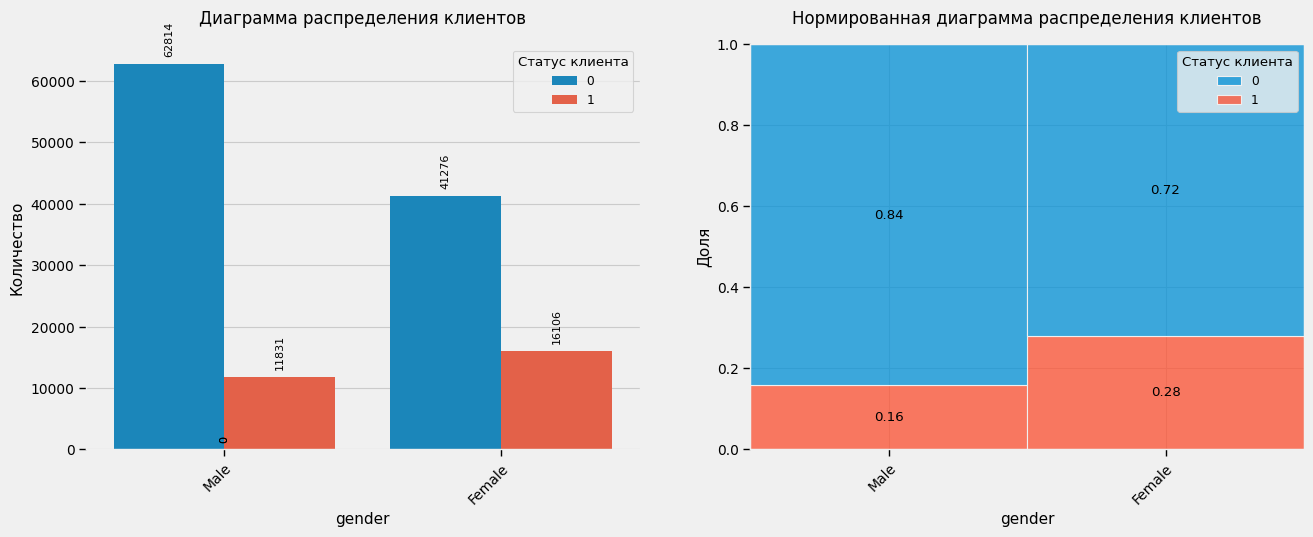

In [37]:
item = 'gender'
show_hist_cat(X_train, item, TARGET, hue_order=target_order, xlabel=f"{item}")

## 6.2. Числовые признаки

In [38]:
X_train[TARGET] = y_train
target_order = [0, 1]
num_fts_global

['creditscore',
 'age',
 'tenure',
 'balance',
 'numofproducts',
 'hascrcard',
 'isactivemember',
 'estimatedsalary']

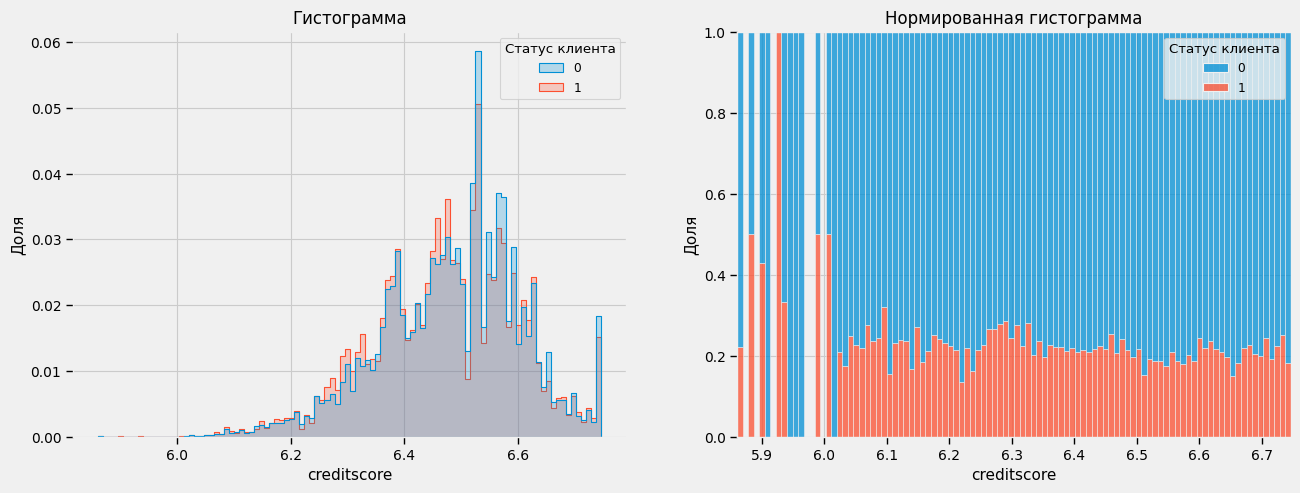

In [39]:
# Покажем для некоторых числовых атрибутов их распределения
for item in ['creditscore']:
    show_histograms(
        np.log1p(X_train[item]),
        X_train[TARGET], 
        hue_order=target_order, 
        annotate=False,
        xlabel=item,
        ylabel='Доля',
        stat='proportion',
    )

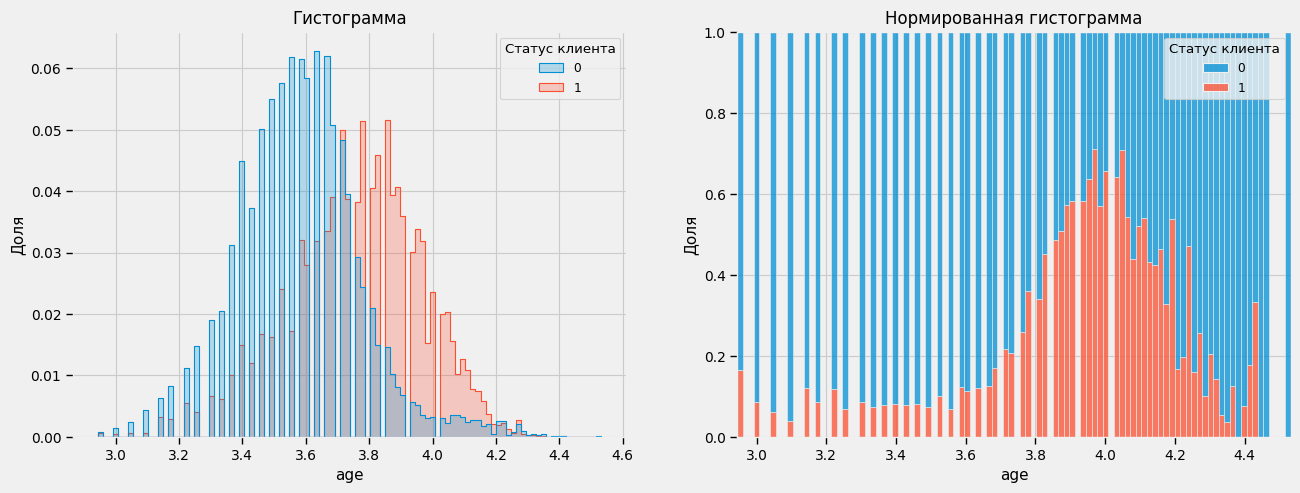

In [40]:
for item in ['age']:
    show_histograms(
        np.log1p(X_train[item]),
        X_train[TARGET], 
        hue_order=target_order, 
        annotate=False,
        xlabel=item,
        ylabel='Доля',
        stat='proportion',
    )

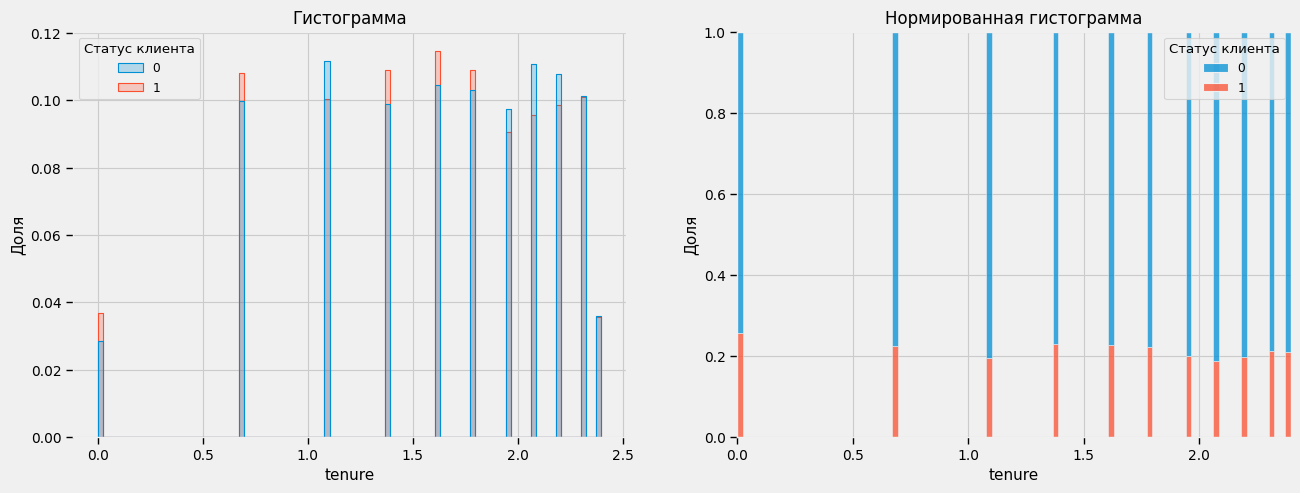

In [41]:
for item in ['tenure']:
    show_histograms(
        np.log1p(X_train[item]),
        X_train[TARGET], 
        hue_order=target_order, 
        annotate=False,
        xlabel=item,
        ylabel='Доля',
        stat='proportion',
    )

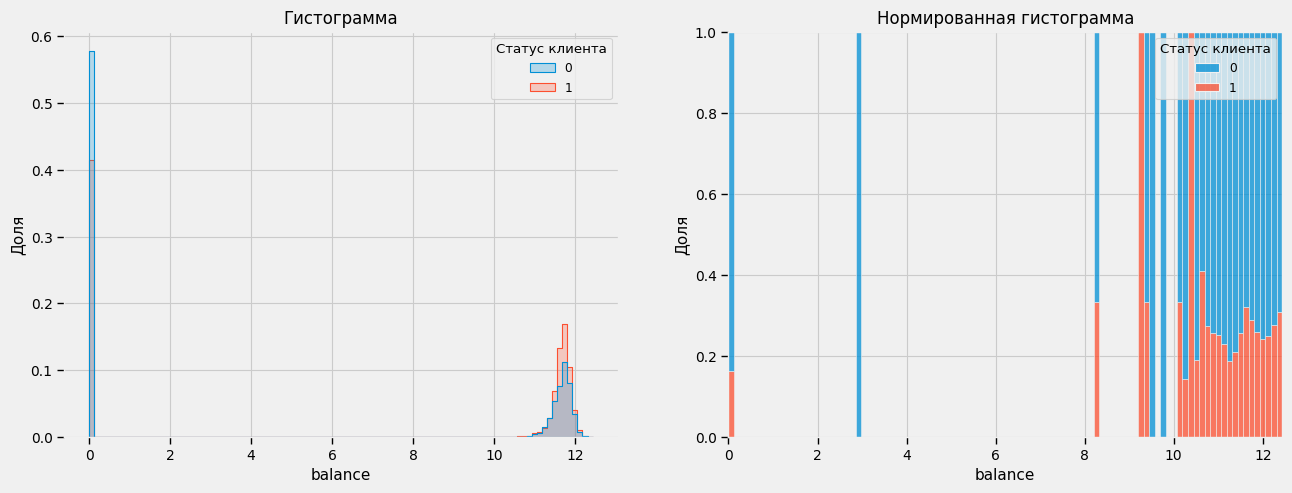

In [42]:
for item in ['balance']:
    show_histograms(
        np.log1p(X_train[item]),
        X_train[TARGET], 
        hue_order=target_order, 
        annotate=False,
        xlabel=item,
        ylabel='Доля',
        stat='proportion',
    )

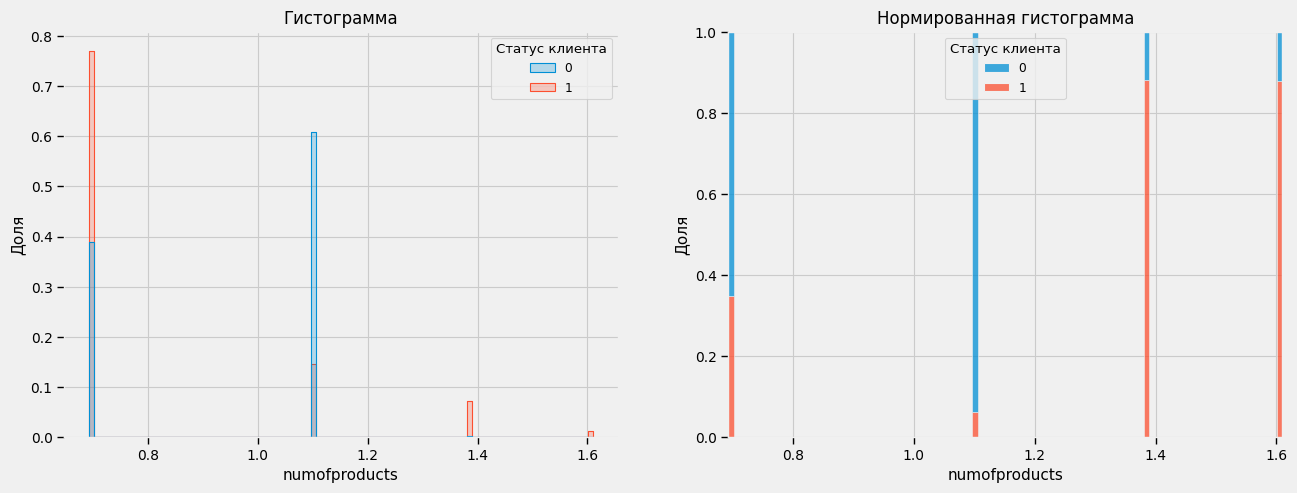

In [43]:
for item in ['numofproducts']:
    show_histograms(
        np.log1p(X_train[item]),
        X_train[TARGET], 
        hue_order=target_order, 
        annotate=False,
        xlabel=item,
        ylabel='Доля',
        stat='proportion',
    )

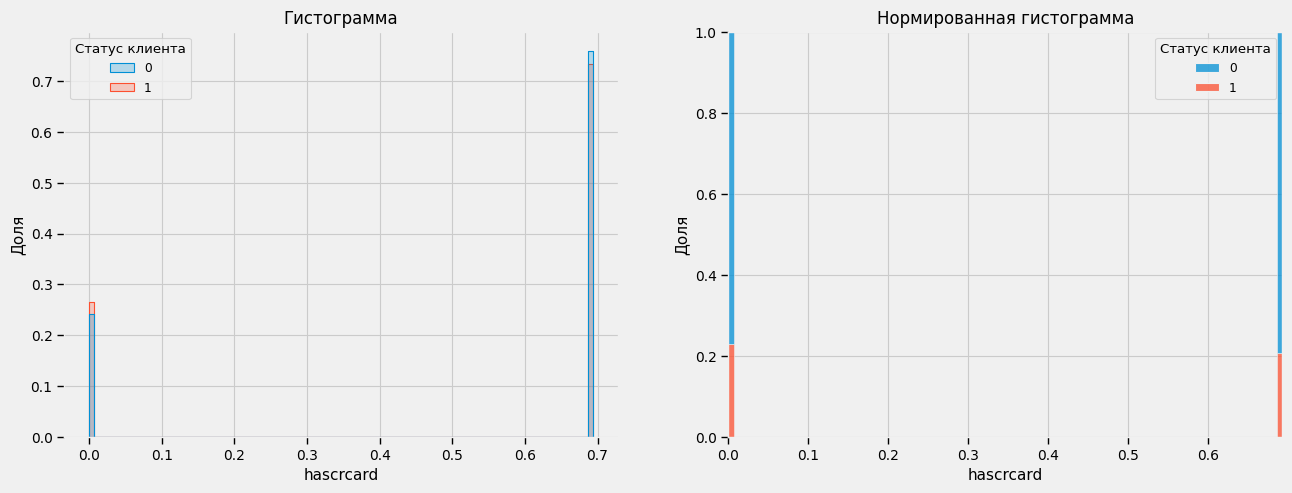

In [44]:
for item in ['hascrcard']:
    show_histograms(
        np.log1p(X_train[item]),
        X_train[TARGET], 
        hue_order=target_order, 
        annotate=False,
        xlabel=item,
        ylabel='Доля',
        stat='proportion',
    )

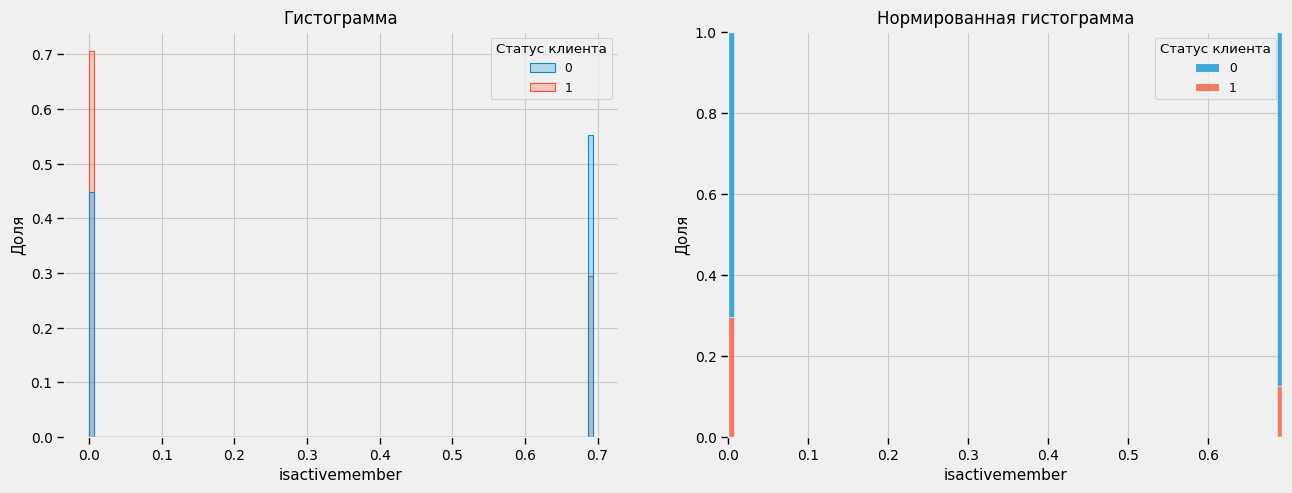

In [45]:
for item in ['isactivemember']:
    show_histograms(
        np.log1p(X_train[item]),
        X_train[TARGET], 
        hue_order=target_order, 
        annotate=False,
        xlabel=item,
        ylabel='Доля',
        stat='proportion',
    )

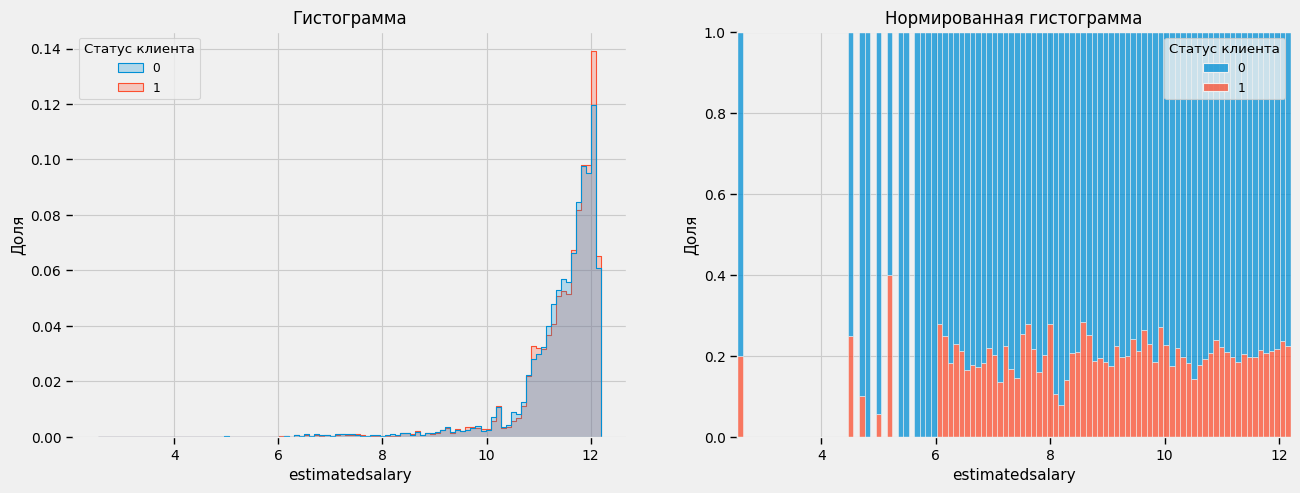

In [46]:
for item in ['estimatedsalary']:
    show_histograms(
        np.log1p(X_train[item]),
        X_train[TARGET], 
        hue_order=target_order, 
        annotate=False,
        xlabel=item,
        ylabel='Доля',
        stat='proportion',
    )

## Чек-лист для пункта Одномерный анализ
- [x] Построены распределения для атрибутов.

# 7. Корреляционный анализ

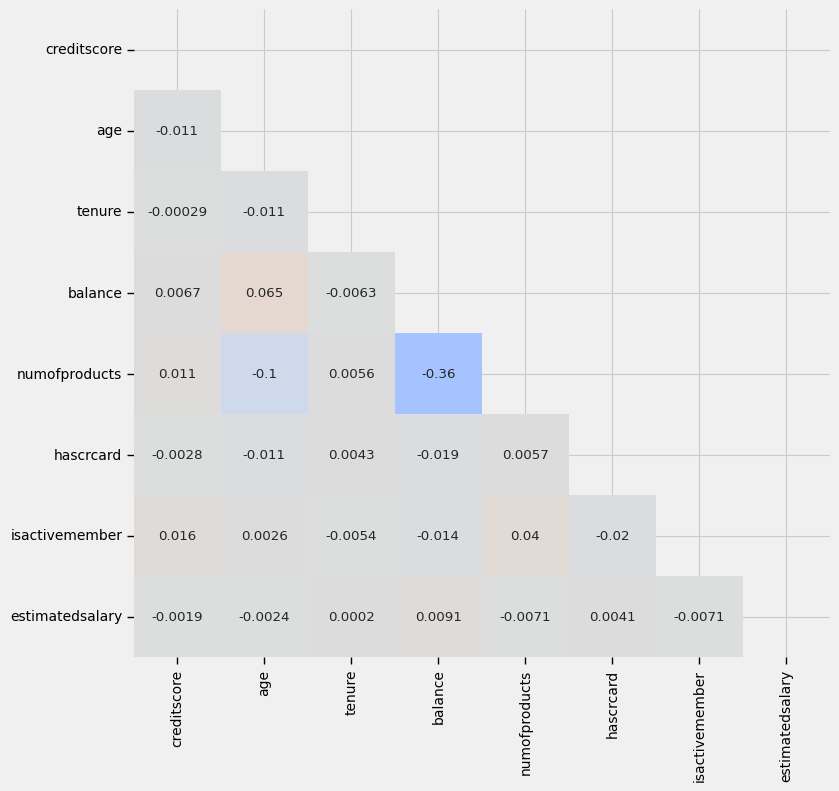

In [47]:
# Определим связь между атрибутами.
# Для примера возьмём только часть атрибутов.
# Отметим что корелляционную матрицу также строит и pandas_profiling
show_corr_matrix(X_train, num_fts, corr_method='pearson', figsize=(8, 8))

In [48]:
clients = X_train[num_fts].copy()
clients[TARGET] = y_train.values
clients

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,target
71021,560,24,6,149382.82,2,1.0,1.0,179171.48,0
30024,584,32,6,123049.21,1,1.0,1.0,65801.44,0
108613,744,39,4,95161.75,1,1.0,1.0,19409.77,0
146238,710,67,6,0.00,2,1.0,1.0,84420.67,0
117342,705,55,2,131365.37,1,1.0,0.0,64771.61,1
...,...,...,...,...,...,...,...,...,...
109215,490,29,4,0.00,2,1.0,1.0,32089.57,0
3301,757,37,4,0.00,2,0.0,0.0,86073.33,0
86621,597,35,2,0.00,1,1.0,0.0,132436.97,1
48920,744,41,5,106260.67,1,1.0,1.0,2578.43,0


In [49]:
# Рекомендуется вывести ТОП-N атрибутов, которые сильно коррелируют с таргетом.
# Для примера возьмём числовые признаки и бинарный таргет.
# В этом случае для меры связи можно использовать:
# а) взаимную информацию б) бисериальный коэффициент корреляции.
# В случае если требуется измерить связь между номинальным атрибутом бинарным таргетом
# можно воспользоваться коэффициентом V Крамера.

clients = X_train[num_fts].copy()
clients[TARGET] = y_train.values

# Рассчитаем скоринг
fts_scores = rank_features(clients, clients['target'], num_fts, seed)
top_scores_mi = pd.DataFrame(
    data={'feature': num_fts,
          'score': [fts_scores[ft] for ft in num_fts]}
).sort_values(by='score', ascending=False, ignore_index=True)

fts_cor = {}
for ft in num_fts:
    mask = ~clients[ft].isnull()
    fts_cor[ft] = stats.pointbiserialr(np.where(clients[mask]['target'] == 1, 1, 0),
                                       np.log1p(clients[mask][ft]))[0]
top_scores_cor = pd.DataFrame(data={'feature': fts_cor.keys(), 'score': fts_cor.values()}) \
    .sort_values(by='score', ascending=False, ignore_index=True, key=abs)

# Отобразим скоринг
n_rows = 20
display_df(
    top_scores_mi.head(n_rows), 
    top_scores_cor.head(n_rows),
    titles=[
        'Взаимная информация', 
        'Коэффициент корреляции'
    ]
)

,feature,score
0,numofproducts,0.08908285
1,age,0.08390685
2,isactivemember,0.03008416
3,balance,0.01482433
4,hascrcard,0.00978168
5,estimatedsalary,0.00655707
6,creditscore,0.00514827
7,tenure,0.00081200
,feature,score
0,age,0.33921232


## Чек-лист для пункта Корреляционный анализ
- [x] Рассчитаны различные меры связи как между атрибутами, так и между атрибутами и таргетом.

# 8. Выводы по результатам EDA

В качестве примера приведу здесь итого по результатм анализа задачи оттока клиентов:
В Германии доля отточных клиентов больше чем в остальных странах
Также больше доля отоочных кллиентов среди женского пола
Отточность клиентов с повышением возраста увеличивается